
# Mean-Field Approximation on an Ising Model: Accuracy vs Coupling Strength

This notebook accompanies the **Mean-Field Approximation on the Ising Model** subsection.

We compare:
- **Exact marginals** computed by brute-force enumeration (feasible for small graphs)
- **Mean-field (MF)** fixed-point solution
- How errors grow with coupling strength and loops

We use a **3×3 grid Ising model** (9 spins → 512 configurations).


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

os.makedirs("figs", exist_ok=True)
np.random.seed(0)


In [2]:

L=3
n=L*L
def idx(r,c): return r*L+c

edges=[]
for r in range(L):
    for c in range(L):
        if r+1<L: edges.append((idx(r,c), idx(r+1,c)))
        if c+1<L: edges.append((idx(r,c), idx(r,c+1)))
edges = sorted(set(tuple(sorted(e)) for e in edges))

def energy(x, J, h):
    e = 0.0
    for (i,j) in edges:
        e -= J * x[i]*x[j]
    e -= np.dot(h, x)
    return e

def exact_marginals(J=0.5, h=None):
    if h is None:
        h = np.zeros(n)
    Z=0.0
    m=np.zeros(n)
    corr=np.zeros((n,n))
    for bits in itertools.product([-1,1], repeat=n):
        x=np.array(bits, dtype=float)
        w=np.exp(-energy(x,J,h))
        Z += w
        m += w*x
        corr += w*np.outer(x,x)
    m /= Z
    corr /= Z
    return m, corr

def mean_field(J=0.5, h=None, iters=800, damping=0.35):
    if h is None:
        h=np.zeros(n)
    neigh=[[] for _ in range(n)]
    for i,j in edges:
        neigh[i].append(j); neigh[j].append(i)
    m=np.zeros(n)
    for _ in range(iters):
        m_new=np.empty_like(m)
        for i in range(n):
            field = h[i] + J*sum(m[j] for j in neigh[i])
            m_new[i] = np.tanh(field)
        m = (1-damping)*m + damping*m_new
    corr = np.outer(m,m)
    np.fill_diagonal(corr, 1.0)
    return m, corr



## Figure 1: Exact vs Mean-Field magnetizations

We apply a small external field at the center node to break symmetry.


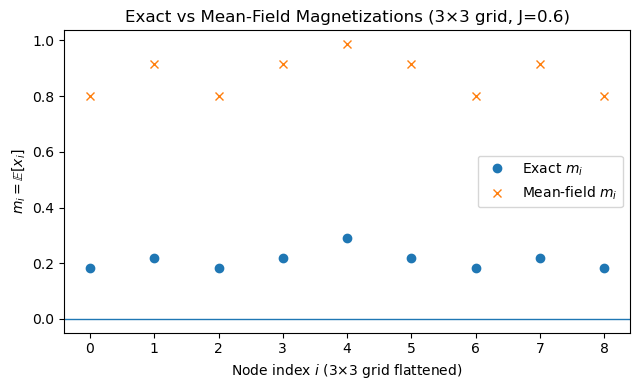

In [3]:

h=np.zeros(n)
h[idx(1,1)] = 0.3  # center field

J=0.6
m_ex, corr_ex = exact_marginals(J, h)
m_mf, corr_mf = mean_field(J, h)

plt.figure(figsize=(6.5,4))
plt.plot(m_ex, "o", label="Exact $m_i$")
plt.plot(m_mf, "x", label="Mean-field $m_i$")
plt.axhline(0, linewidth=1)
plt.xlabel("Node index $i$ (3×3 grid flattened)")
plt.ylabel(r"$m_i=\mathbb{E}[x_i]$")
plt.title(f"Exact vs Mean-Field Magnetizations (3×3 grid, J={J})")
plt.legend()
plt.tight_layout()
plt.savefig("figs/mf_vs_exact_magnetizations.png", dpi=150)
plt.show()



## Figure 2: Correlation error heatmap

Mean-field ignores correlations beyond products of means. We visualize
$\Delta_{ij}=\langle x_i x_j\rangle_{\rm exact}-\langle x_i x_j\rangle_{\rm MF}$.


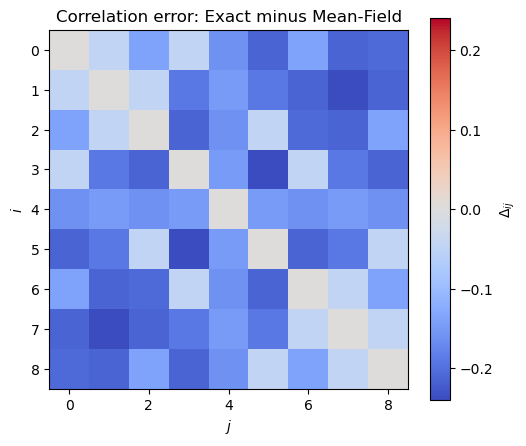

In [4]:

Delta = corr_ex - corr_mf

plt.figure(figsize=(5.4,4.6))
plt.imshow(Delta, aspect="equal", cmap="coolwarm",
           vmin=-np.max(np.abs(Delta)), vmax=np.max(np.abs(Delta)))
plt.colorbar(label=r"$\Delta_{ij}$")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("Correlation error: Exact minus Mean-Field")
plt.tight_layout()
plt.savefig("figs/mf_correlation_error_heatmap.png", dpi=150)
plt.show()



## Figure 3: Error vs coupling strength

We sweep $J$ and measure mean absolute errors in magnetizations and correlations.


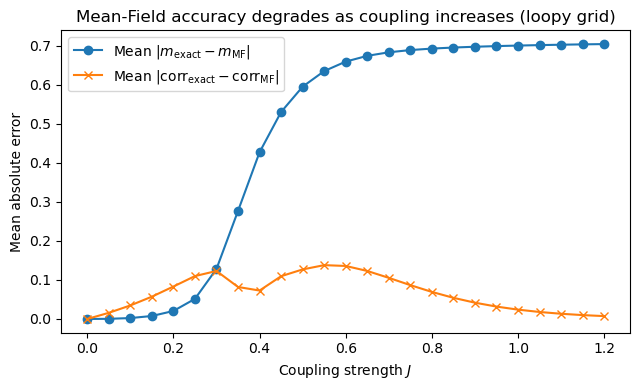

In [5]:

Js = np.linspace(0.0, 1.2, 25)
err_m=[]
err_c=[]

for Jv in Js:
    m_ex, c_ex = exact_marginals(Jv, h)
    m_mf, c_mf = mean_field(Jv, h)
    err_m.append(np.mean(np.abs(m_ex - m_mf)))
    err_c.append(np.mean(np.abs(c_ex - c_mf)))

plt.figure(figsize=(6.5,4))
plt.plot(Js, err_m, marker="o", label=r"Mean $|m_{\rm exact}-m_{\rm MF}|$")
plt.plot(Js, err_c, marker="x", label=r"Mean $|\mathrm{corr}_{\rm exact}-\mathrm{corr}_{\rm MF}|$")
plt.xlabel("Coupling strength $J$")
plt.ylabel("Mean absolute error")
plt.title("Mean-Field accuracy degrades as coupling increases (loopy grid)")
plt.legend()
plt.tight_layout()
plt.savefig("figs/mf_error_vs_coupling.png", dpi=150)
plt.show()



**Takeaway.** Mean-field is fast and often useful as a baseline, but loops and stronger
couplings create correlations that a fully factorized surrogate cannot represent.
